In [1]:
from pathlib import Path
from enum import Enum
import cv2
from cv2 import imwrite
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from time import time
from scipy.optimize import curve_fit
%matplotlib inline
import scipy.stats
from util import parse_fn, is_bg
from scipy import stats
from scipy.stats import skewnorm
from scipy.special import erf
from scipy.special import voigt_profile

In [2]:

# def intensity(file):
#     with open(file, "rb") as rawimage:
    
#         bayer_image = np.fromfile(rawimage, np.dtype('u1'))
        
#         #data = np.array(data)    
#         raw_pixel = bayer_image.reshape((540, 600))
#     return raw_pixel

# def intensity_to_blue_norm(intensity):
#     intensity_uint16 = np.array(intensity, dtype = np.uint16)
#     color = cv2.cvtColor(intensity_uint16, cv2.COLOR_BayerRGGB2BGR)
#     color_norm = test_color/65535
#     blue = color_norm[:,:,0]
#     return blue
    
# def get_blue_norm(file):
#     raw_pixel = read_raw_to_intensity(file)
#     blue = intensity_to_blue_norm(raw_pixel)
#     return blue


In [3]:
HEADER_LEN = 152 
X_DIM = 1200 
Y_DIM = 1920

x1, x2 = 160, 250
y1, y2 = 200, 525

In [4]:
def read_raw_to_intensity(file):
    
    with open(file, "rb") as rawimage:
    
        bayer_image = np.fromfile(rawimage, np.dtype('u1'), offset = HEADER_LEN)
        fst_byte, scd_byte = bayer_image.reshape((bayer_image.shape[0]//2, 2)).astype(np.uint16).T
        raw_pixel = (fst_byte + (scd_byte << 8)).reshape((X_DIM, Y_DIM))
#         data = []
#         data = np.zeros(X_DIM * Y_DIM)
        
#         for i in range(0,len(bayer_image)//2):
#             val = bayer_image[2*i] +  (bayer_image[2*i+1] << 8) # bayer_image[2*i+1]*256
#             data[i] = val # data.append(val) this slow
        
#         data = np.array(data)    
#         raw_pixel = data.reshape((X_DIM, Y_DIM))
    return raw_pixel


def intensity_to_blue_16(intensity):
    intensity_uint16 = np.array(intensity, dtype = np.uint16)
    color = cv2.cvtColor(intensity_uint16, cv2.COLOR_BayerGRBG2RGB) #cv.COLOR_BayerBG2RGB #BayerRGGB2BGR #GRBG2RGB
    #color_norm = test_color/65535
    blue = color[:,:,2]
    return blue


def get_blue(file):
    raw_pixel = read_raw_to_intensity(file)
    blue = intensity_to_blue_16(raw_pixel)
    return blue.astype(np.float64)

def get_bright(pure_blue):
    data = pure_blue[300:640,600:1250]
    return data

# 拿到我要的範圍的blue
def get_data(file):
    x1, x2 = 150, 250
    y1, y2 = 200, 525
    blue = get_blue(file)
    bright = get_bright(blue)
    data = bright[x1:x2, y1:y2]
    return data

# 加入可有可無的那種inputs
def fit(func, line):
    xdata = np.linspace(0, len(line) - 1, len(line))
    ydata = line
    popt, pcov = curve_fit(func, xdata, ydata, maxfev = 8000)
    return popt
    #plt.plot(xdata, func(xdata, *popt), 'g--')
         #label='' % tuple(popt))
        
def get_max(line, func):
    par = fit(func, line)
    values = func(np.linspace(0, len(line) - 1, len(line)), *par) 
    return np.max(values)

def get_maxs(data,func):
    x1, x2 = 160, 250
    y1, y2 = 200, 525
    maxs = np.zeros(x2-x1)
    for i in range(x2 - x1):
        line = data[i,:]
        line_max = get_max(line, func)
        maxs[i] = line_max
    return maxs

# 拿到 dR/R of a frame
def peak_dRoverR(file, b_file, func, maxs_func):
    blue = get_data(file)
    b_blue = get_data(b_file)
    dRoverR = (blue - b_blue) / b_blue
    maxs = get_maxs(dRoverR, func)
    peak = get_max(maxs, maxs_func)
    return peak

In [5]:
def gaus(x,a,x0,sigma):
    return a* np.exp(-(x-x0)**2/(2*sigma**2))

def poly2(x, a, b, c):
    return a*(x**2) + b*x + c

def poly3(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*x + d

def poly4(x, a, b, c, d, e):
    return a*(x**4) + b*(x**3) + c*(x**2) + d*x + e

def poly5(x, a, b, c, d, e, f):
    return a*(x**5) + b*(x**4) + c*(x**3) + d*(x**2) + e*x + f

def poly8(x, a, b, c, d, e, f, g, h, i):
    return a*(x**8) + b*(x**7) + c*(x**6) + d*(x**5) + e*(x**4) + f*(x**3) + g*(x**2) + h*x + i


def poly10(x, a, b, c, d, e, f, g, h, i, j, k):
    return a*(x**10) + b*(x**9) + c*(x**8) + d*(x**7) + e*(x**6) + f*(x**5) + g*(x**4) + h*(x**3) + i*(x**2) + j*x + k

def skew(x, a, loc, scale):
    return skewnorm.pdf(x, a, loc, scale)  

def lognorm(x, s, loc, scale):
    return scipy.stats.lognorm.pdf(x, s, loc, scale)

def cauchy(x, loc, scale):
    return scipy.stats.cauchy.pdf(x, loc, scale)

def pdf(x):
    return 1/math.sqrt(2*math.pi) * np.exp(-x**2/2)

def cdf(x):
    return (1 + erf(x/math.sqrt(2))) / 2

def skew_b(x,a,b,c):
    t = (x-a) / b
    return 2 / b * pdf(t) * cdf(c*t)


def log(x, a, b):
    return a + b * np.log(x)

def expo(x, a, b, c):
    return a*np.exp(-b*x) + c

def lorentz(x, height, x_0, width_x):
    return height / (1+((x-x_0)/width_x)**2) 


def two_lorentz(x, height, x_0, sigma_1, sigma_2):
    return ( lorentz(x, height, x_0, sigma_1)*(x<=x_0).astype(int)+lorentz(x, height, x_0, sigma_2)*(x>x_0).astype(int) )        

def voigt(x, sigma, gamma):
    return voigt_profile(x, sigma, gamma)

In [6]:
from sklearn.metrics import r2_score

def r2(line, func):
    popt, pcov = curve_fit(func, np.linspace(0, len(line) - 1, len(line)), line)
    y_pred = func(np.linspace(0, len(line) - 1, len(line)), *popt)
    return r2_score(line, y_pred)

def rsq(line, func):
    popt, pcov = curve_fit(func, np.linspace(0, len(line) - 1, len(line)), line)
    y_pred = func(np.linspace(0, len(line) - 1, len(line)), *popt)
    residuals = line - func(np.linspace(0, len(line) - 1, len(line)), *popt)
    ss_res = np.sum(residuals**2)
    return ss_res

In [7]:
file = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/45mm per sec/15mm_43W_025.raw"
b_file = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/45mm per sec/15mm_0W_025.raw"

In [8]:
start = time()
peak_dRoverR(file, b_file, poly5, gaus)
print(time()-start)

4.227877140045166


In [9]:
blue = get_blue(file)
b_blue = get_blue(b_file)

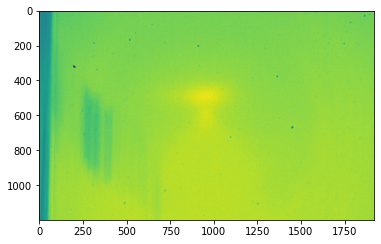

In [10]:
plt.imshow(blue)

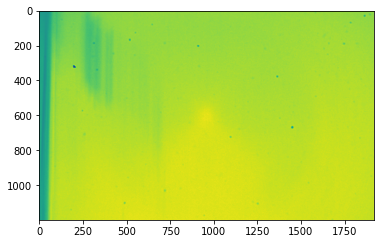

In [11]:
plt.imshow(b_blue)

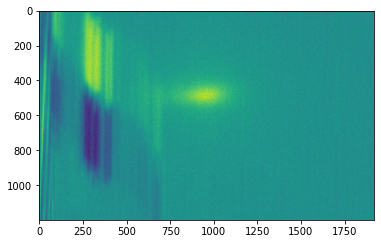

In [12]:
plt.imshow(blue-b_blue)

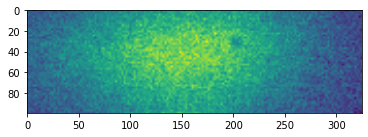

In [13]:
data = get_data(file)
plt.imshow(data)

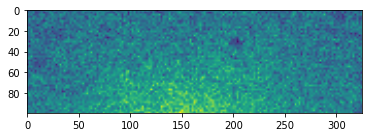

In [14]:
b_data = get_data(b_file)
plt.imshow(b_data)

(100, 325)

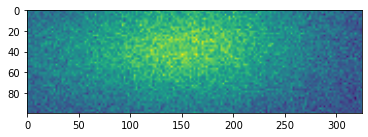

In [15]:
target = (data - b_data) / b_data
plt.imshow(target)
target.shape

# compare...

In [16]:
dT1 = target/ kappa
T1 = dT1 + 25
plt.imshow(T1)

NameError: name 'kappa' is not defined

In [ ]:
a1 = T1[:, 251]
plt.plot(np.linspace(0,99,100), a1, ".")
plt.plot(gaus(np.linspace(0,99,100), *fit(gaus, a1)), 'orange')
trend1 = gaus(np.linspace(0,99,100), *fit(gaus, a1))
np.max(gaus(np.linspace(0,99,100), *fit(gaus, a1)))


In [ ]:
file_2 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/45mm per sec/15mm_37W_025.raw"
b_file_2 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/45mm per sec/15mm_0W_025.raw"
data_2 = get_data(file_2)
b_data_2 = get_data(b_file_2)
target2 = (data_2 - b_data_2) / b_data_2

dT2 = target2/ kappa
T2 = dT2 + 25
plt.imshow(T2)

In [ ]:
a2 = T2[:, 150]
plt.plot(np.linspace(0,99,100), a2, ".")
plt.plot(gaus(np.linspace(0,99,100), *fit(gaus, a2)), 'orange')
trend2 = gaus(np.linspace(0,99,100), *fit(gaus, a2))

np.max(gaus(np.linspace(0,99,100), *fit(gaus, a2)))

In [ ]:
plt.plot(trend1, 'r')
plt.plot(trend2, 'b')

# fit peak

0.124047500001407

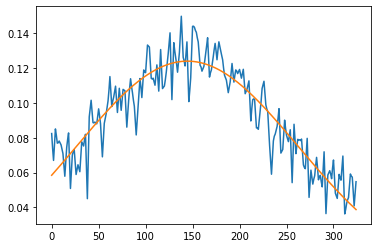

In [17]:
line = target[50, :]
X = np.linspace(0, len(line) - 1, len(line))
plt.plot(line)
plt.plot(X, gaus(X, *fit(gaus, line)))
np.max(gaus(X, *fit(gaus, line)))


0.8075439621848084 0.04467323163342185


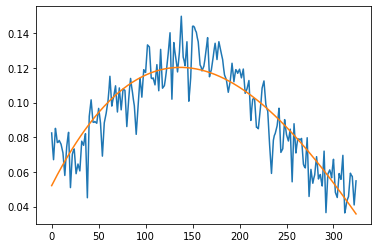

In [47]:
plt.plot(line)
plt.plot(X, poly3(X, *fit(poly3, line)))
np.max(poly3(X, *fit(poly3, line)))
print(r2(line, poly3), rsq(line, poly3))

0.12751785980191221

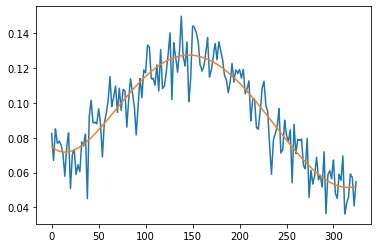

In [48]:
plt.plot(line)
plt.plot(X, poly5(X, *fit(poly5, line)))
np.max(poly5(X, *fit(poly5, line)))


0.880545295136696 0.027728034727519422


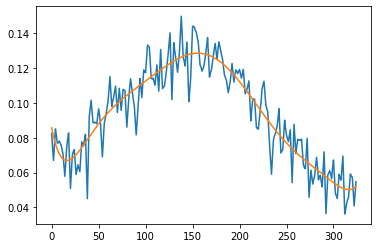

In [49]:
plt.plot(line)
plt.plot(X, poly8(X, *fit(poly8, line)))
np.max(poly8(X, *fit(poly8, line)))
print(r2(line, poly8), rsq(line, poly8))

0.12747762370488855

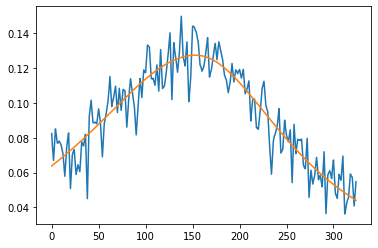

In [50]:
plt.plot(line)
plt.plot(X, two_lorentz(X, *fit(two_lorentz, line)))
np.max(two_lorentz(X, *fit(two_lorentz, line)))

0.10832557514412669

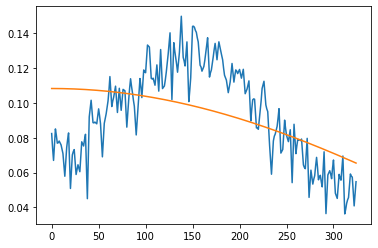

In [52]:
plt.plot(line)
plt.plot(X, voigt(X, *fit(voigt, line)))
np.max(voigt(X, *fit(voigt, line)))


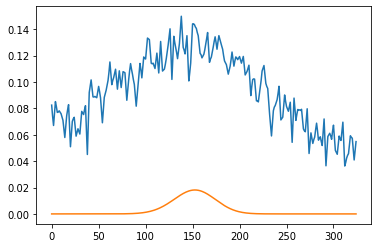

In [53]:
plt.plot(line)
popt, pcov = curve_fit(skew, X, line, p0 = [1, 150, 10], maxfev=5000)
#a, loc, scale = stats.skewnorm.fit(line)
#plt.plot(X, skewnorm.pdf(X, a, loc, scale ))
plt.plot(X, skew(X, *popt))

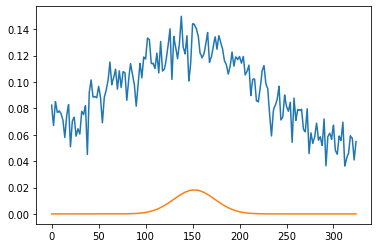

In [54]:
plt.plot(line)
popt, pcov = curve_fit(skew_b, X, line, p0 = [10, 150, 1], maxfev=5000)
plt.plot(X, skew_b(X, *popt))

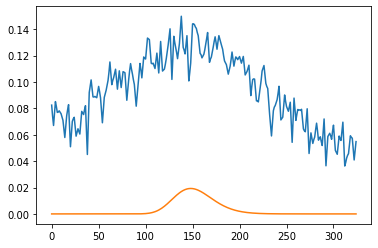

In [55]:
plt.plot(line)
popt, pcov = curve_fit(lognorm, X, line, p0 = [10, 150, 1], maxfev=5000)
plt.plot(X, lognorm(X, *popt))



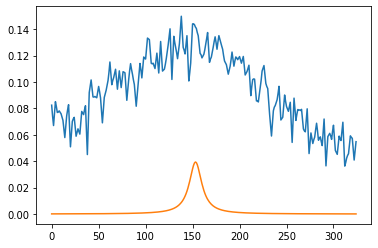

In [56]:
plt.plot(line)
popt, pcov = curve_fit(cauchy, X, line, maxfev=5000)
plt.plot(X, cauchy(X, *popt))

# kappa

In [30]:
import os
files = []
for file in os.listdir("/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/103mm per sec"):
    if file.endswith("_025.raw"):
        name = str(os.path.join("/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/103mm per sec", file))
        files.append(name)
        
b_file = files[0]

In [31]:
del files[0]

In [32]:
dRoverR = []
for file in files:
    val = peak_dRoverR(file, b_file, poly5, gaus)
    dRoverR.append(val)
len(dRoverR)

17

In [39]:
power = np.linspace(29,57,15)
power

array([29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53.,
       55., 57.])

In [38]:
del dRoverR[len(dRoverR)-1]

Text(0, 0.5, 'dR/R')

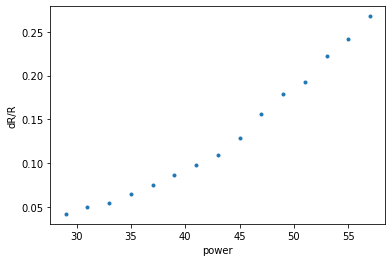

In [40]:
plt.plot(power, dRoverR, '.')
plt.xlabel("power")
plt.ylabel("dR/R")


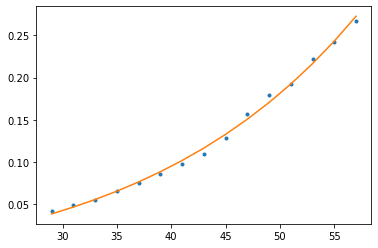

In [41]:
popt, pcov = curve_fit(expo, power, dRoverR, p0 = [1, 0.0000001, 1], maxfev = 5000)
plt.plot(power, dRoverR, '.')
plt.plot(power, expo(power, *popt))


In [42]:
a, b, c = popt
a, b, c

(0.018483534018494306, -0.04958642012224118, -0.039325108517036335)

In [43]:
y_pred = expo(power, *popt)
residuals = dRoverR - expo(power, *popt)
ss_res = np.sum(residuals**2)
ss_res

0.00028356773276661093

In [44]:
f = expo(54, *popt)
gold_m = 1064
dT = gold_m - 25

In [45]:
kappa = f / dT
kappa

0.00022101123074765218

# frame trend (same v and power)

In [17]:
import glob, os
os.chdir("/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/45mm per sec")
thefiles =[]
for file in glob.glob("*39W*"):
    file = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412/45mm per sec"+"/"+file
    thefiles.append(file)

In [18]:
del thefiles[0]

In [19]:
b_file = thefiles[0]
files = thefiles[1:29]

In [20]:
tem = []
for file in files:
    dRoverR = peak_dRoverR(file, b_file, poly5, gaus)
    T = dRoverR / kappa + 25
    tem.append(T)

NameError: name 'kappa' is not defined

In [ ]:
plt.plot(np.linspace(1,28,28),tem,".")

In [ ]:
def get_T()